# Offline Twitter Analysis

This notebook is used to:
* read historydata.
* make basic transformations.
* make an explorational data analysis.
* calculate predictions and save them for online stream analysis.

## The data
The data contents summaries of metrics for unique combinations of the hashtags(case-unsensitive):
* #Trump
* #News
* #FakeNews
* #Democrats
* #Politics
The combination is generated with boolean flags for every hashtag.
If a tweet does not contain any of these hashtags, it links to a valid combination aswell. This combination is therefore '[false,false,false,false,false]'.

Summaries about the last 60 seconds are recorded every second for every unique hashtag combination. If a combination did not occure in this timewindow, no summary is recorded for this combination.

### Used metrics
Following metrics were calculated for every occuring hashtag combination in a timewindow of the last 60 seconds:
* count - The total count of tweets for this combination
* meanTextLength - the mean length of a not truncated tweet (hashtags and mentions included)
* meanHashtagCount - The mean count of hashtags
* meanTrumpCount - The mean occurences of the word 'trump' in the tweet texts; not case-sensitive.
* meanSensitiveCount - The mean count of tweets flagged as "Possibly sensitive". (Flagging performed by Twitter)

These metrics are used to generate a prediction for hashtag combinations w.r.t. the time of the day.

## Used libaries
Make sure those are installed.

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta

### Plotting
And display in notebook.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (16.0, 9.0)
%matplotlib inline

## Reading history CSV files

In [3]:
# The main working directory
mainDir = ""

comboHistoryFile = mainDir + "comboHistory.csv"
#allTweetsFile = mainDir + "tweetHistory.csv"

# The prediction filepaths
outputFile = mainDir + "timePredictions.csv"
evalFile = mainDir + "predictionsEvaluation.csv"

In [4]:
comboHistory = pd.read_csv(comboHistoryFile,
                           sep=";", 
                           header = 0)
# commented out 
#allTweets = pd.read_csv(allTweetsFile,
#                        sep=";", 
#                        header = 0)

if 'allTweets' in locals():
    print("Number of processed tweets: " + str(len(allTweets)))
print("Number of summaries for hashtag-combinations: " + str(len(comboHistory)))

Number of summaries for hashtag-combinations: 17175


The data has following columns:

In [5]:
comboHistory.columns

Index(['timestamp', 'time', 'isTrumpTweet', 'isNewsTweet', 'isFakeNewsTweet',
       'isDemocratsTweet', 'isPoliticsTweet', 'count', 'meanTextLength',
       'meanHashtagCount', 'meanTrumpCount', 'meanSensitiveCount'],
      dtype='object')

In [6]:
comboHistory['timestamp'] = pd.to_datetime(comboHistory['timestamp']) + timedelta(hours=1)
comboHistory['time'] = pd.to_datetime(comboHistory['time']).apply(lambda x: x.time())

In [7]:
# group by hashtag combination, calculate mean values of metrics
meanMetrics = comboHistory.groupby(['isTrumpTweet','isNewsTweet','isFakeNewsTweet','isDemocratsTweet','isPoliticsTweet'])['count', 
                                                                                                                          'meanTextLength', 
                                                                                                                          'meanHashtagCount', 
                                                                                                                          'meanTrumpCount', 
                                                                                                                          'meanSensitiveCount'].agg(np.mean).reset_index()

In [8]:
comboHistory.loc[0:10,['timestamp','time']]

,timestamp,time
0,2017-11-27 20:40:48,20:40:48
1,2017-11-27 20:42:16,20:42:16
2,2017-11-27 20:42:16,20:42:16
3,2017-11-27 20:42:17,20:42:17
4,2017-11-27 20:42:17,20:42:17
5,2017-11-27 20:42:18,20:42:18
6,2017-11-27 20:42:18,20:42:18
7,2017-11-27 20:42:19,20:42:19
8,2017-11-27 20:42:19,20:42:19
9,2017-11-27 20:42:20,20:42:20


In [9]:
print("Found " + str(len(meanMetrics)) + " unique hashtag combinations")

Found 14 unique hashtag combinations


## Plots

#### Data splitting
We want various combinations of data for analysis.

In [10]:
comboList = list()
for i in range(0, len(meanMetrics)):
    comboList.append(meanMetrics.loc[i,['isTrumpTweet',
                                        'isNewsTweet',
                                        'isFakeNewsTweet',
                                        'isDemocratsTweet',
                                        'isPoliticsTweet']].to_frame().transpose())

In [11]:
comboTimeseriesList = list()
for i in range(0,len(comboList)):
    comboTimeseriesList.append(comboList[i]
                               .merge(comboHistory,on=['isTrumpTweet',
                                                       'isNewsTweet',
                                                       'isFakeNewsTweet',
                                                       'isDemocratsTweet',
                                                       'isPoliticsTweet']))

#### Plotfunction definition:

In [12]:
def plotMetric(df,metricName):
    traces = list()
    
    fig = plt.figure(figsize=(16,9))
    ax = plt.axes()

    for i in range(0,len(df)):
        df.plot(y=metricName, kind = 'bar', label=i, ax=ax)
    ax.legend().set_visible(False)

    plt.ylabel(metricName)
    
    plt.title('Mean of Metric: ' + metricName, fontsize=18)

In [13]:
def plotMetricTimeseries(dfList, metricName, timeName = 'timestamp', skip=0):
    traces = list()
    
    fig = plt.figure(figsize=(16,9))
    ax = plt.axes()

    for i in range(skip,len(dfList)):
        df = dfList[i]
        df.plot(x=timeName, y=metricName, label=i, ax=ax, linewidth = 0.5)
        
    titleStr= 'Timeseries of Metric: ' + metricName
    
    
    plt.xlabel(timeName)
    plt.ylabel(metricName)
    plt.suptitle('Timeseries of Metric: ' + metricName, fontsize=18)
    
    if(skip>0):
       plt.title('(skipped ' + str(skip) + ' datarows)', fontsize=10)
    
    plt.legend()

Due to the quantity of unique combinations, refer to this table for index-combo linking.

In [14]:
meanMetrics.loc[:,['isTrumpTweet','isNewsTweet','isFakeNewsTweet','isDemocratsTweet','isPoliticsTweet']]

,isTrumpTweet,isNewsTweet,isFakeNewsTweet,isDemocratsTweet,isPoliticsTweet
0,False,False,False,False,False
1,False,False,False,False,True
2,False,False,False,True,False
3,False,False,False,True,True
4,False,False,True,False,False
5,False,False,True,False,True
6,False,True,False,False,False
7,False,True,False,False,True
8,True,False,False,False,False
9,True,False,False,False,True


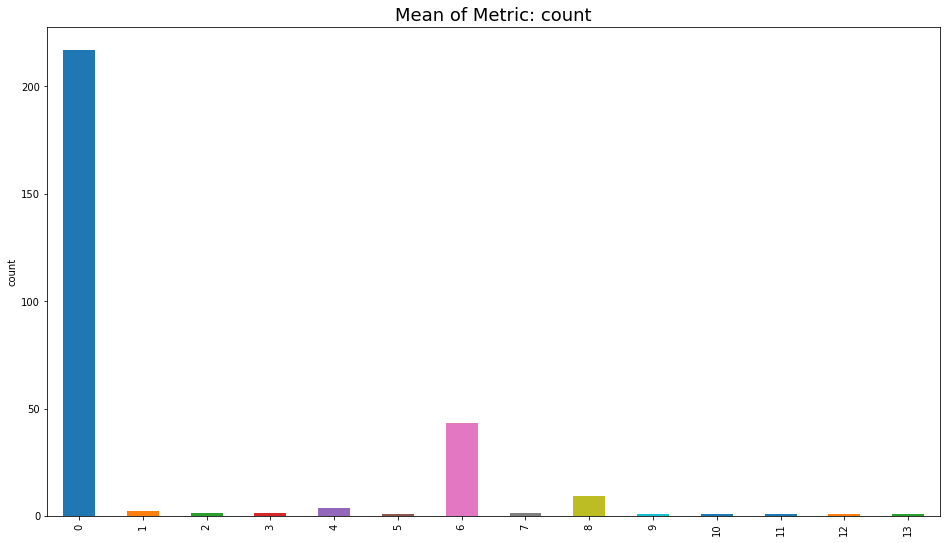

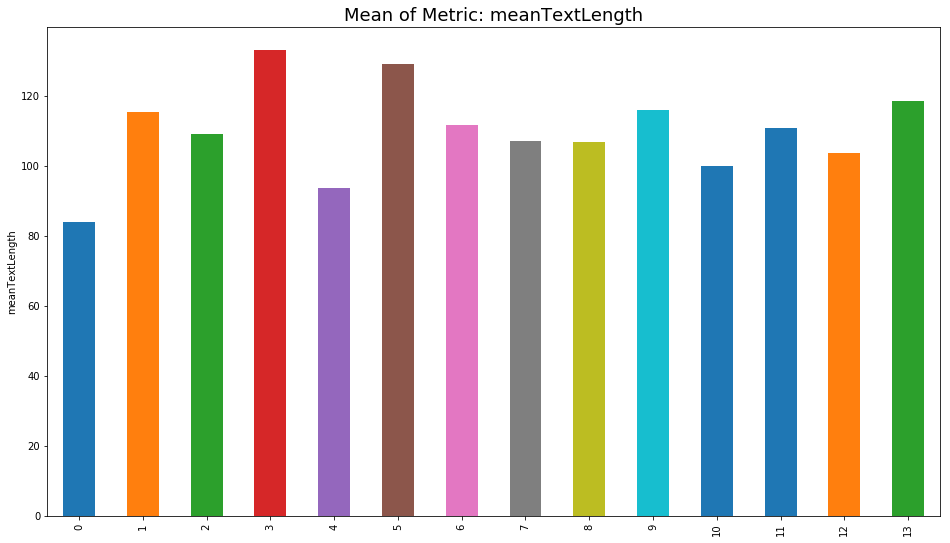

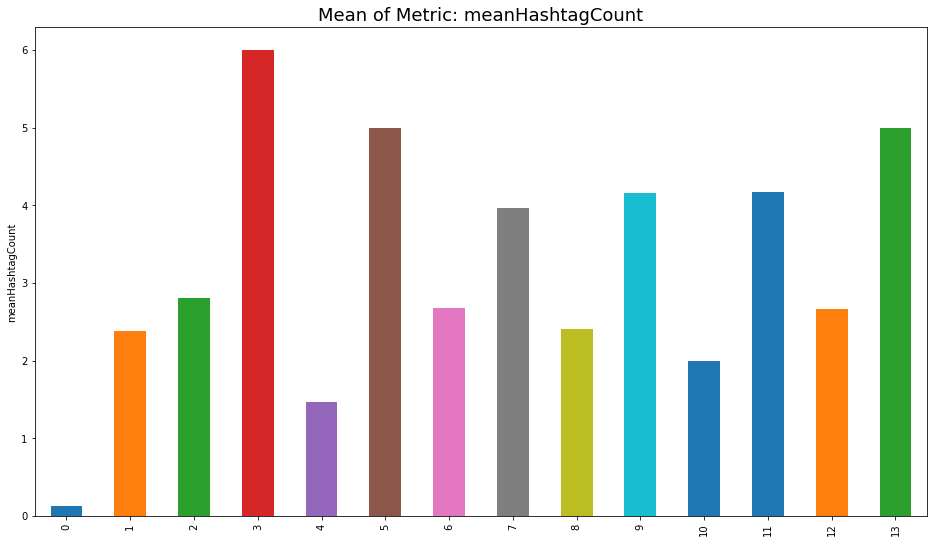

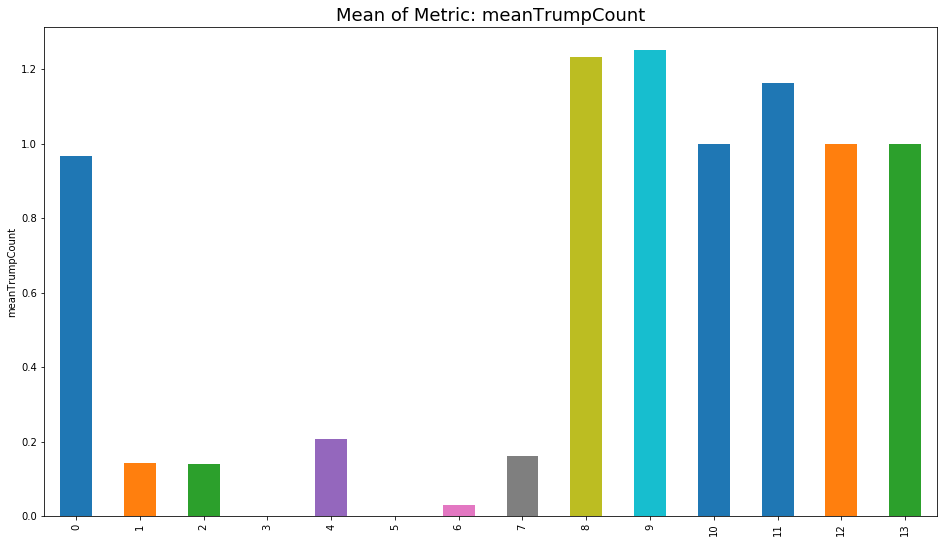

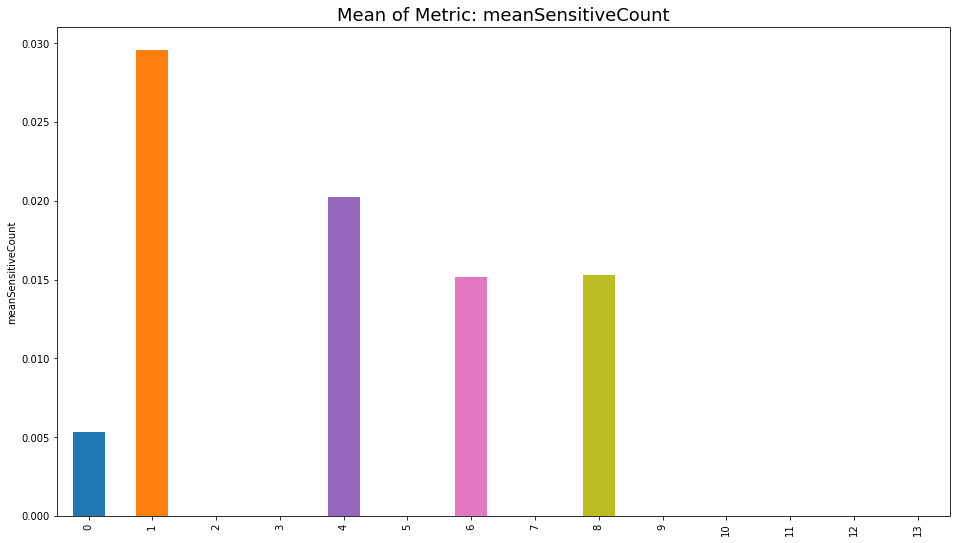

In [15]:
plotMetric(meanMetrics, 'count')
plotMetric(meanMetrics, 'meanTextLength')
plotMetric(meanMetrics, 'meanHashtagCount')
plotMetric(meanMetrics, 'meanTrumpCount')
plotMetric(meanMetrics, 'meanSensitiveCount')

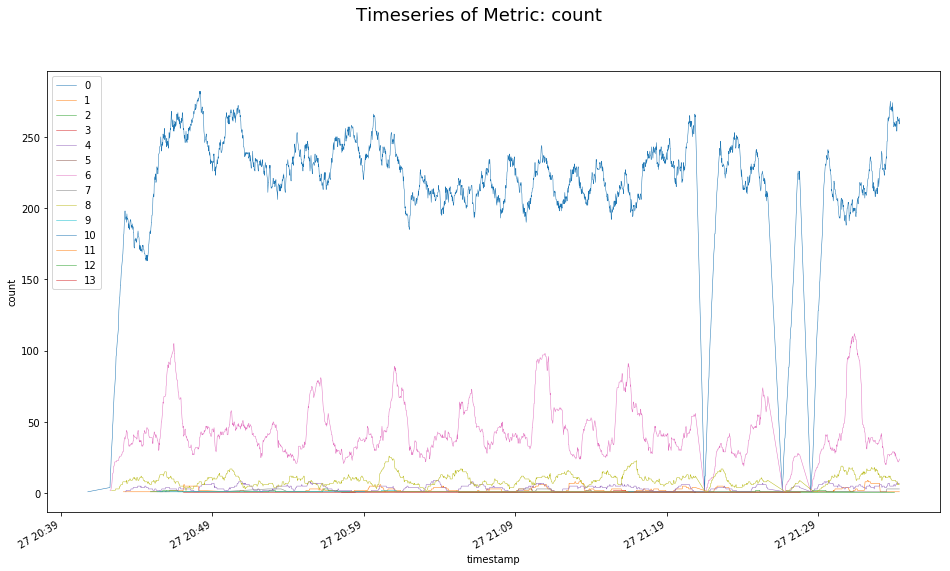

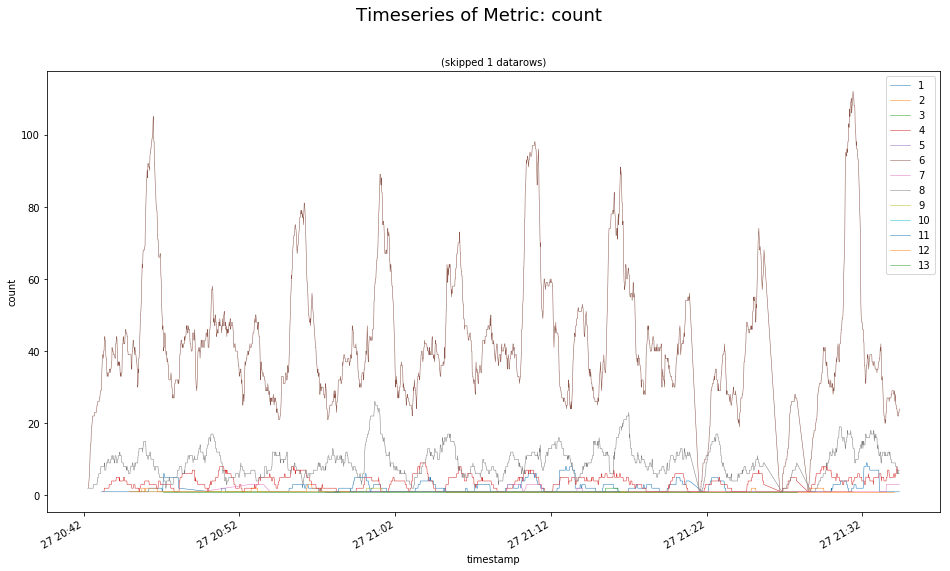

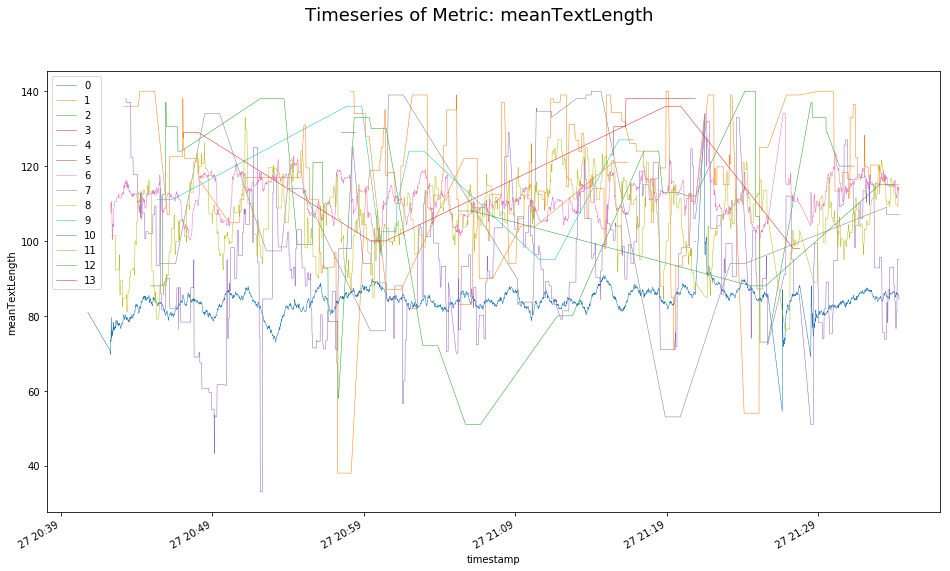

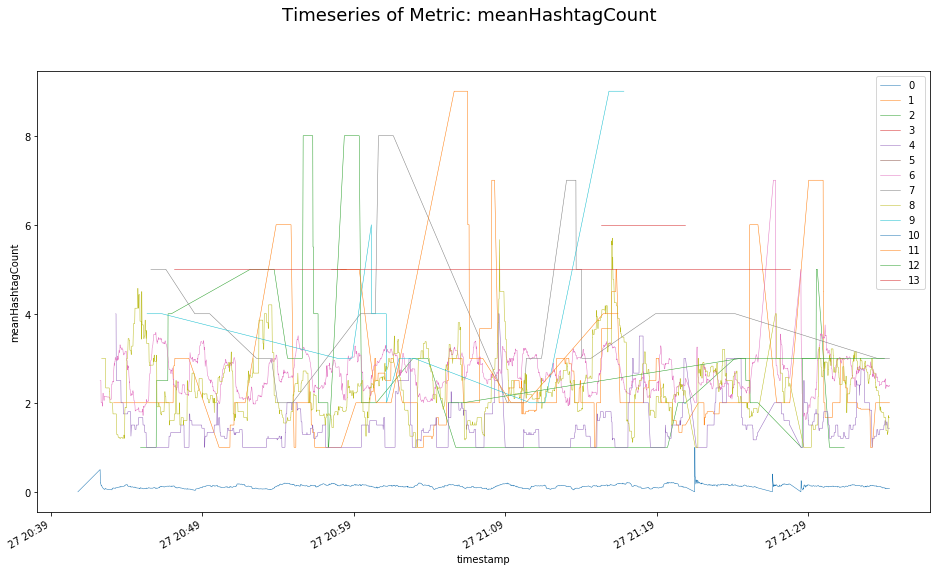

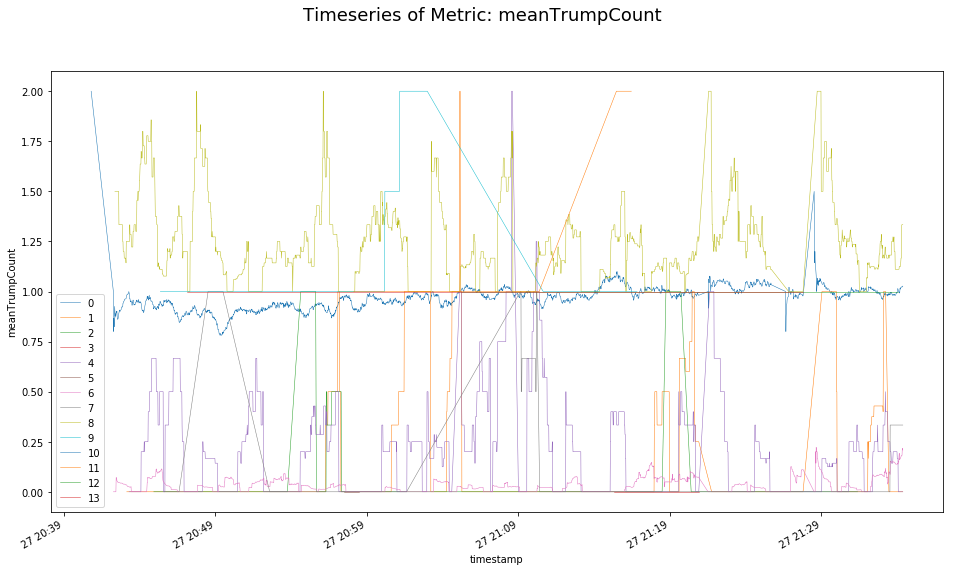

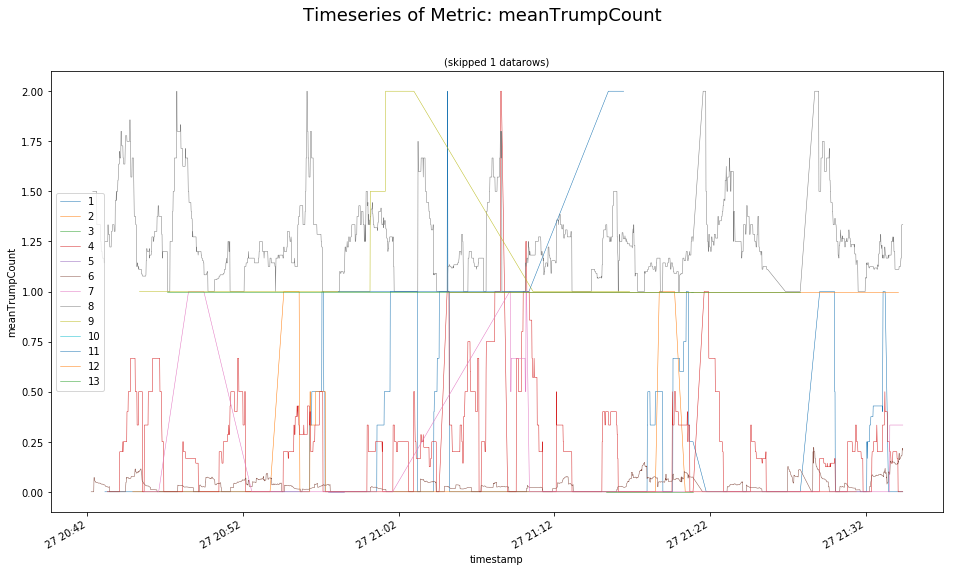

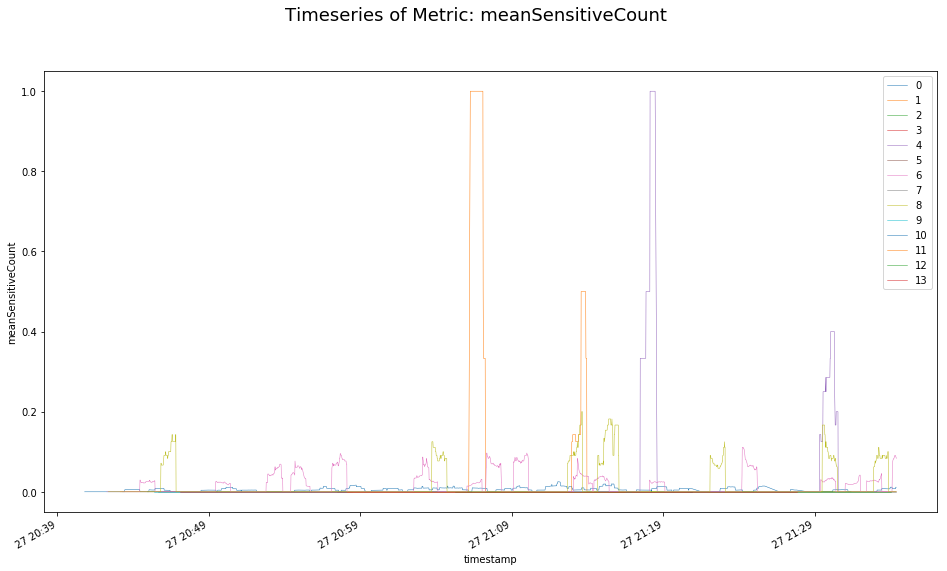

In [16]:
plotMetricTimeseries(comboTimeseriesList, 'count')
plotMetricTimeseries(comboTimeseriesList, 'count', skip = 1)
plotMetricTimeseries(comboTimeseriesList, 'meanTextLength')
plotMetricTimeseries(comboTimeseriesList, 'meanHashtagCount')
plotMetricTimeseries(comboTimeseriesList, 'meanTrumpCount')
plotMetricTimeseries(comboTimeseriesList, 'meanTrumpCount', skip = 1)
plotMetricTimeseries(comboTimeseriesList, 'meanSensitiveCount')

## Predictions
This approach merges the entries by their time (without a date) and their combo.    
The goal is to achieve a mean-value for each combo and each second of a day.

This mean value functions as prediction for this metric. The Spark application will use and evaluate this prediction.

In [17]:
newComboHistory = comboHistory.copy()

In [18]:
# transform timestamp strings to datetime format
offsetH = 0
offsetm = 0
offsets = 0
newComboHistory['time'] = newComboHistory['timestamp'] + timedelta(hours=offsetH, minutes = offsetm, seconds = offsets)
newComboHistory['time'] = newComboHistory['time'].apply(lambda x: x.time())

In [19]:
newComboHistory.loc[0:5,['timestamp','time']]

,timestamp,time
0,2017-11-27 20:40:48,20:40:48
1,2017-11-27 20:42:16,20:42:16
2,2017-11-27 20:42:16,20:42:16
3,2017-11-27 20:42:17,20:42:17
4,2017-11-27 20:42:17,20:42:17
5,2017-11-27 20:42:18,20:42:18


In [20]:
timePredictions = newComboHistory.groupby(['time',
                                           'isTrumpTweet',
                                           'isNewsTweet',
                                           'isFakeNewsTweet',
                                           'isDemocratsTweet',
                                           'isPoliticsTweet'])['count',
                                                               'meanTextLength',
                                                               'meanHashtagCount', 
                                                               'meanTrumpCount', 
                                                               'meanSensitiveCount'].agg(np.mean).reset_index()

## Plot predictions

In [21]:
timePredictionsList = list()
for i in range(0,len(comboList)):
    timePredictionsList.append(comboList[i]
                               .merge(timePredictions,on=['isTrumpTweet',
                                                          'isNewsTweet',
                                                          'isFakeNewsTweet',
                                                          'isDemocratsTweet',
                                                          'isPoliticsTweet']))

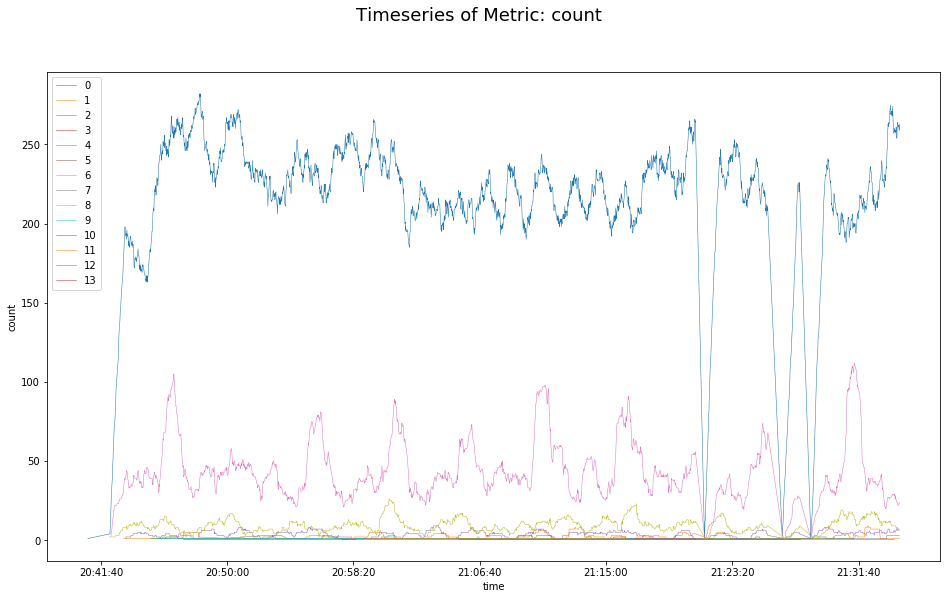

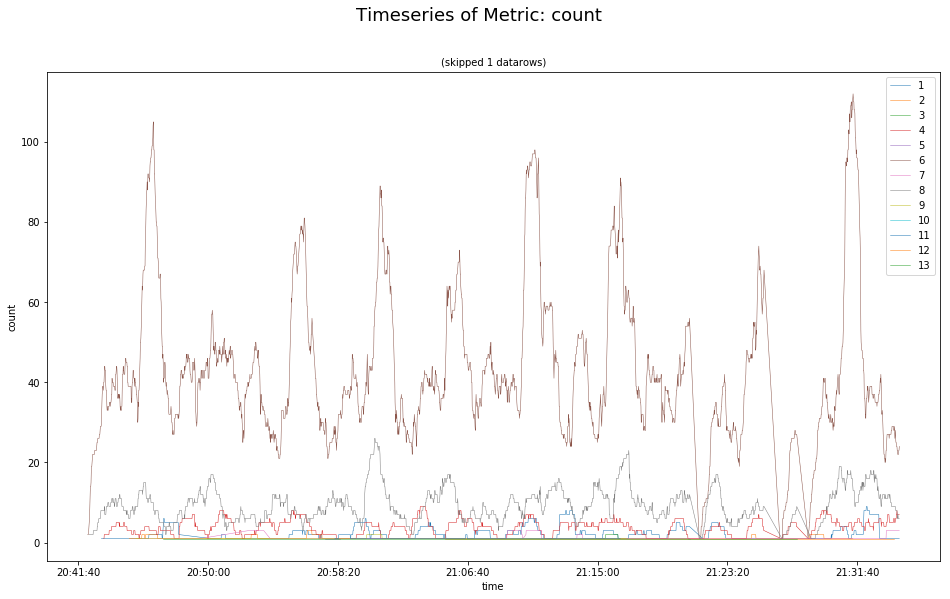

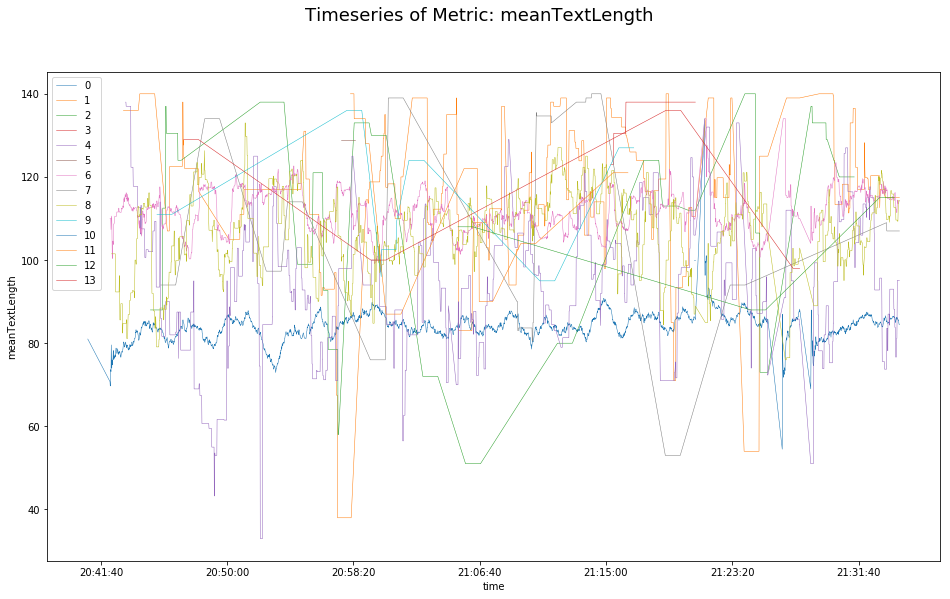

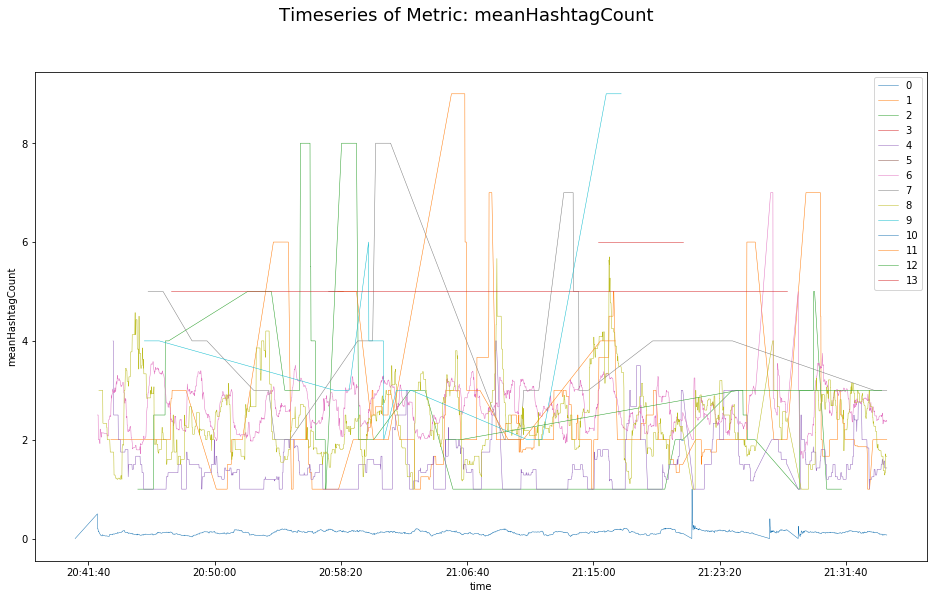

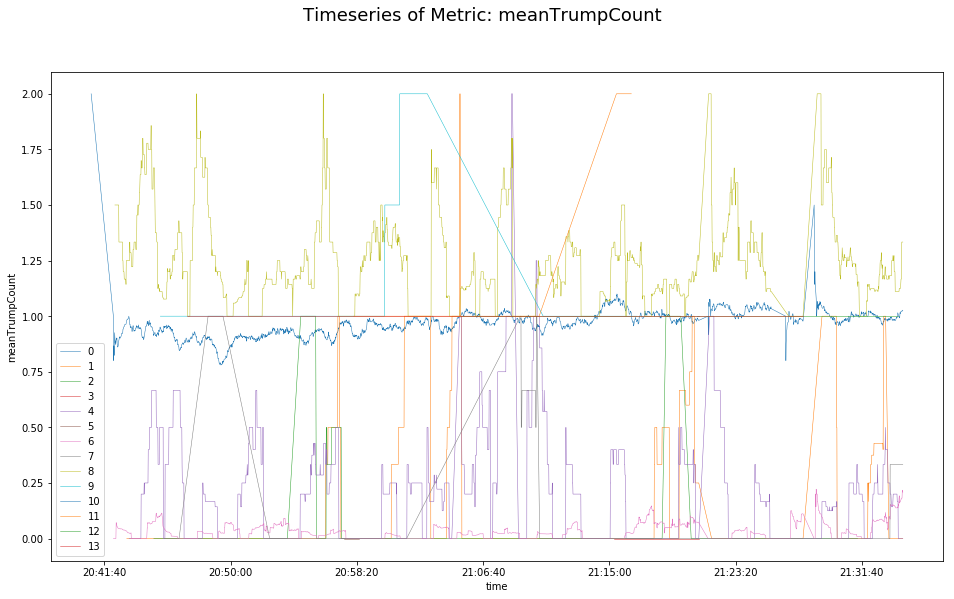

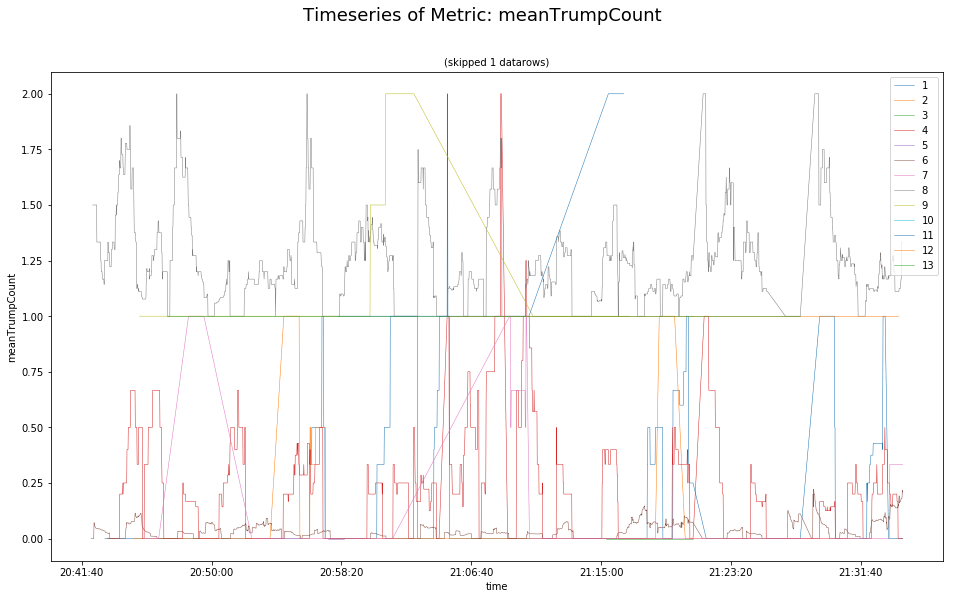

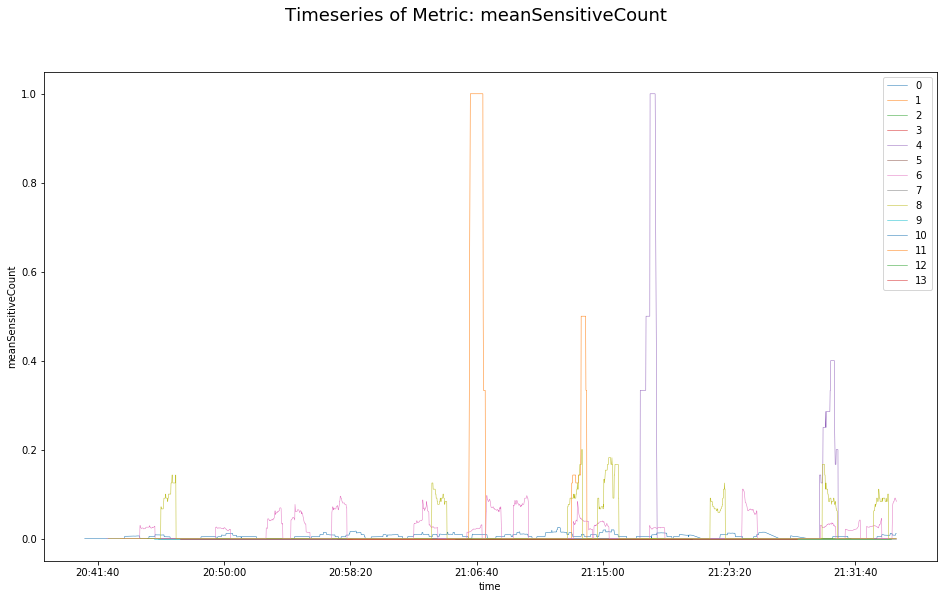

In [22]:
plotMetricTimeseries(timePredictionsList, 'count', timeName = 'time')
plotMetricTimeseries(timePredictionsList, 'count', timeName = 'time', skip = 1)
plotMetricTimeseries(timePredictionsList, 'meanTextLength', timeName = 'time')
plotMetricTimeseries(timePredictionsList, 'meanHashtagCount', timeName = 'time')
plotMetricTimeseries(timePredictionsList, 'meanTrumpCount', timeName = 'time')
plotMetricTimeseries(timePredictionsList, 'meanTrumpCount', timeName = 'time', skip = 1)
plotMetricTimeseries(timePredictionsList, 'meanSensitiveCount', timeName = 'time')

#### Save predictions as csv file

In [23]:
timePredictions.to_csv(outputFile,
                       sep=';',
                       quotechar='"',
                       quoting=2,
                       index=False)

## Predictions Evaluation

#### Read prediction evaluation

In [24]:
predEvaluation = pd.read_csv(evalFile,
                             sep=";", 
                             header = 0)

In [25]:
predEvaluation.columns

Index(['timestamp', 'time', 'isTrumpTweet', 'isNewsTweet', 'isFakeNewsTweet',
       'isDemocratsTweet', 'isPoliticsTweet', 'errorCount',
       'errorMeanTextLength', 'errorMeanHashtagCount', 'errorMeanTrumpCount',
       'errorMeanSensitiveCount'],
      dtype='object')

#### Transformation

In [26]:
# transform timestamp strings to datetime format
predEvaluation['timestamp'] = pd.to_datetime(predEvaluation['timestamp']) + timedelta(hours=1)
predEvaluation['time'] = pd.to_datetime(predEvaluation['time']).apply(lambda x: x.time())

In [27]:
predEvaluation[0:5]

,timestamp,time,isTrumpTweet,isNewsTweet,isFakeNewsTweet,isDemocratsTweet,isPoliticsTweet,errorCount,errorMeanTextLength,errorMeanHashtagCount,errorMeanTrumpCount,errorMeanSensitiveCount
0,2017-11-27 21:28:31,21:28:31,False,False,False,False,False,-244.0,11.231707,0.036585,-0.597561,0.004065
1,2017-11-27 21:28:31,21:28:31,False,False,True,False,False,-5.0,9.666667,0.500000,0.166667,0.000000
2,2017-11-27 21:28:31,21:28:31,False,True,False,False,False,-42.0,13.976744,-2.023256,0.023256,0.000000
3,2017-11-27 21:30:07,21:30:07,True,False,False,False,False,-4.0,-3.583333,-0.354167,-0.250000,-0.083333
4,2017-11-27 21:30:07,21:30:07,False,False,False,False,False,-49.0,4.086657,-0.011379,-0.096029,0.007634


In [28]:
# group by hashtag combination, calculate mean values of metrics
meanEvals = predEvaluation.groupby(['isTrumpTweet',
                                    'isNewsTweet',
                                    'isFakeNewsTweet',
                                    'isDemocratsTweet',
                                    'isPoliticsTweet'])['errorCount',
                                                        'errorMeanTextLength',
                                                        'errorMeanHashtagCount',
                                                        'errorMeanTrumpCount',
                                                        'errorMeanSensitiveCount'].agg(np.mean).reset_index()

In [29]:
meanEvals

,isTrumpTweet,isNewsTweet,isFakeNewsTweet,isDemocratsTweet,isPoliticsTweet,errorCount,errorMeanTextLength,errorMeanHashtagCount,errorMeanTrumpCount,errorMeanSensitiveCount
0,False,False,False,False,False,-15.604396,-0.815946,0.056658,-0.106949,-0.001465
1,False,False,False,False,True,1.033333,-4.414815,2.000000,-0.266667,0.000000
2,False,False,True,False,False,1.835165,3.807875,-0.103676,0.119963,-0.060623
3,False,True,False,False,False,11.439560,-0.067582,-0.328581,-0.039492,-0.033025
4,False,True,False,False,True,1.965517,7.034483,-1.000000,-0.339080,0.000000
5,True,False,False,False,False,-1.455556,3.303946,-0.211919,-0.091881,-0.015576


In [30]:
evalList = list()
for i in range(0, len(meanEvals)):
    evalList.append(meanEvals.loc[i,['isTrumpTweet','isNewsTweet','isFakeNewsTweet','isDemocratsTweet','isPoliticsTweet']].to_frame().transpose())

In [31]:
evalTimeseriesList = list()
for i in range(0,len(evalList)):
    evalTimeseriesList.append(evalList[i]
                              .merge(predEvaluation,on=['isTrumpTweet',
                                                        'isNewsTweet',
                                                        'isFakeNewsTweet',
                                                        'isDemocratsTweet',
                                                        'isPoliticsTweet']))

#### Plots

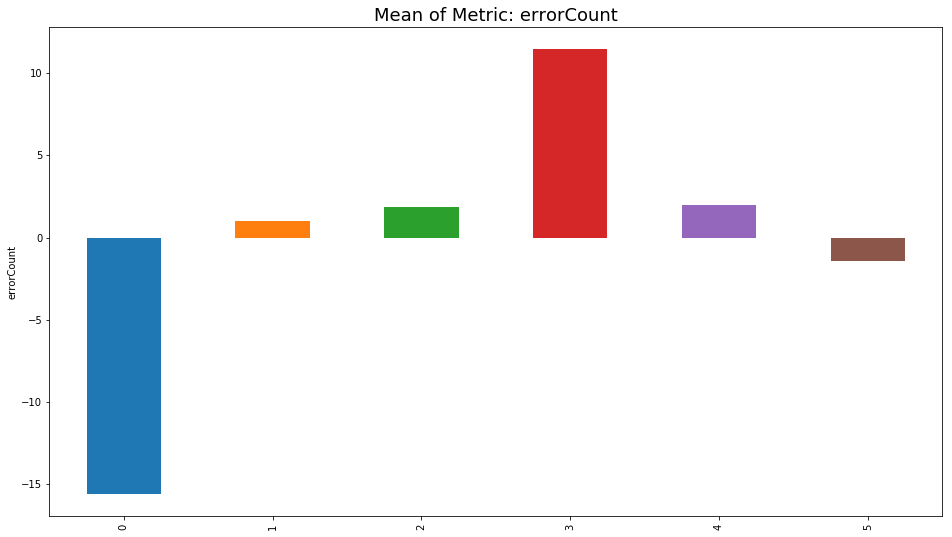

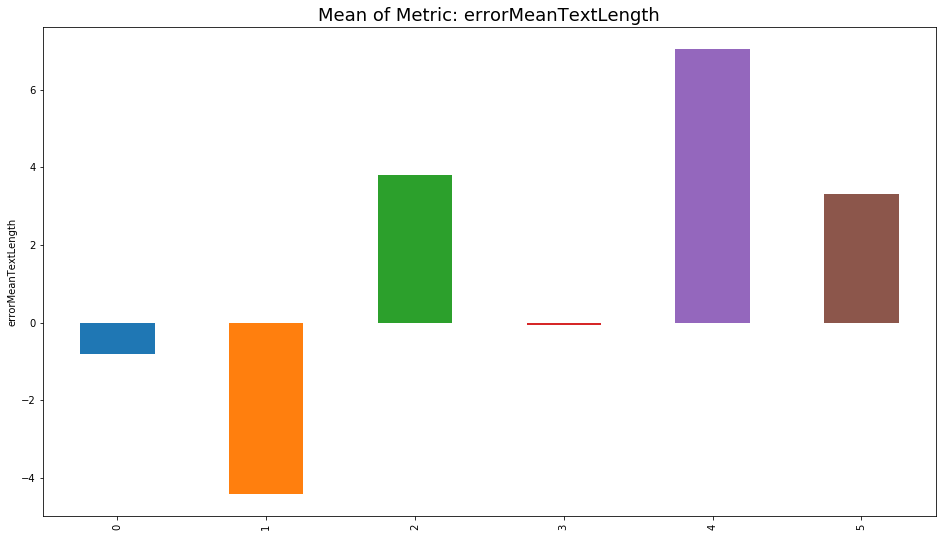

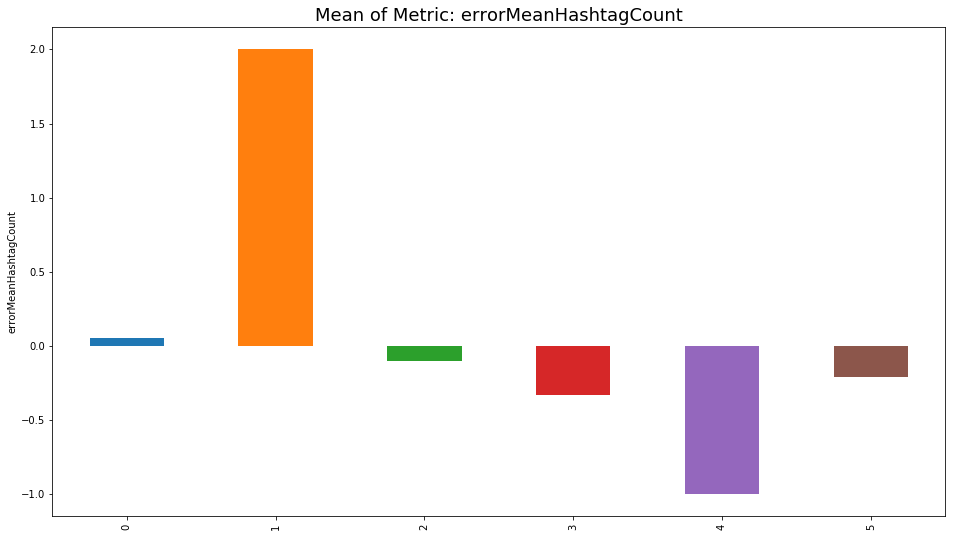

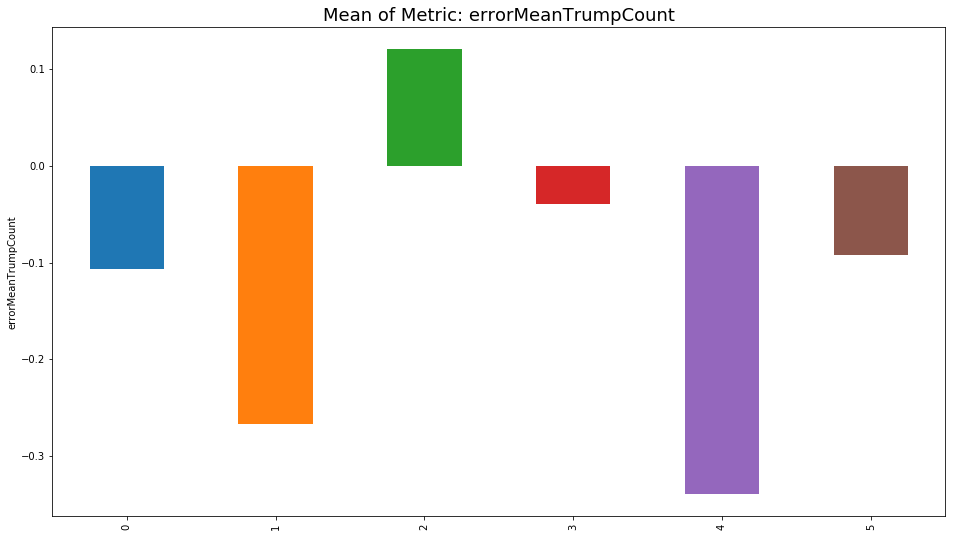

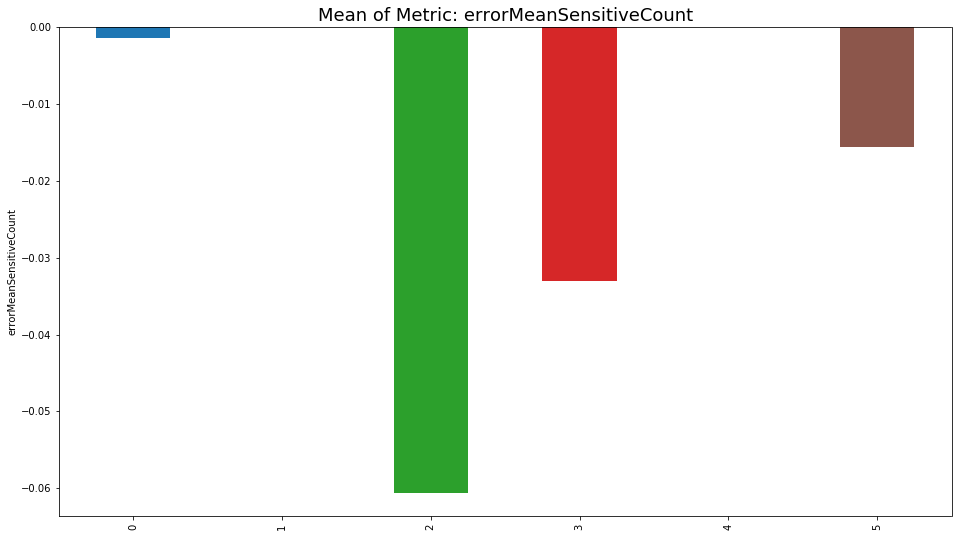

In [32]:
plotMetric(meanEvals, 'errorCount')
plotMetric(meanEvals, 'errorMeanTextLength')
plotMetric(meanEvals, 'errorMeanHashtagCount')
plotMetric(meanEvals, 'errorMeanTrumpCount')
plotMetric(meanEvals, 'errorMeanSensitiveCount')

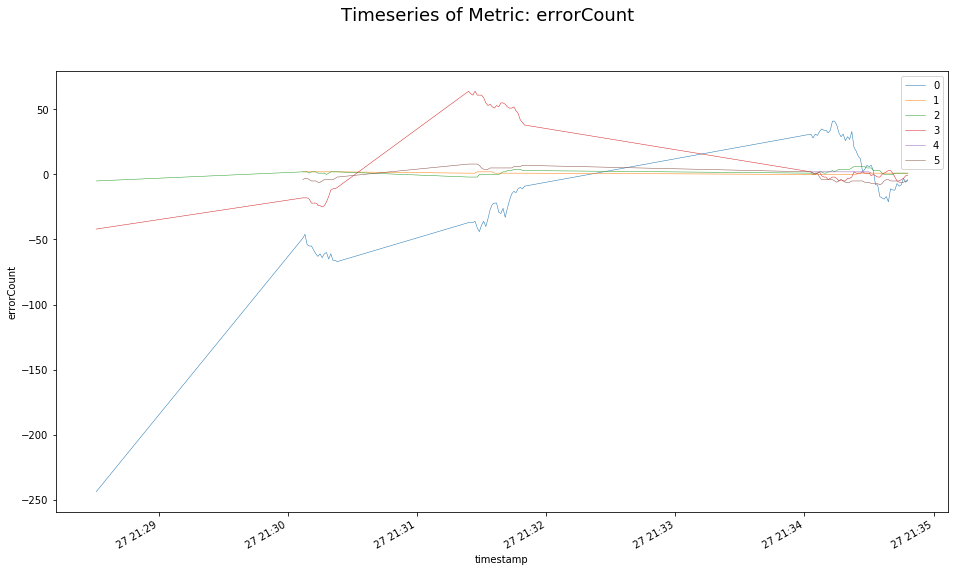

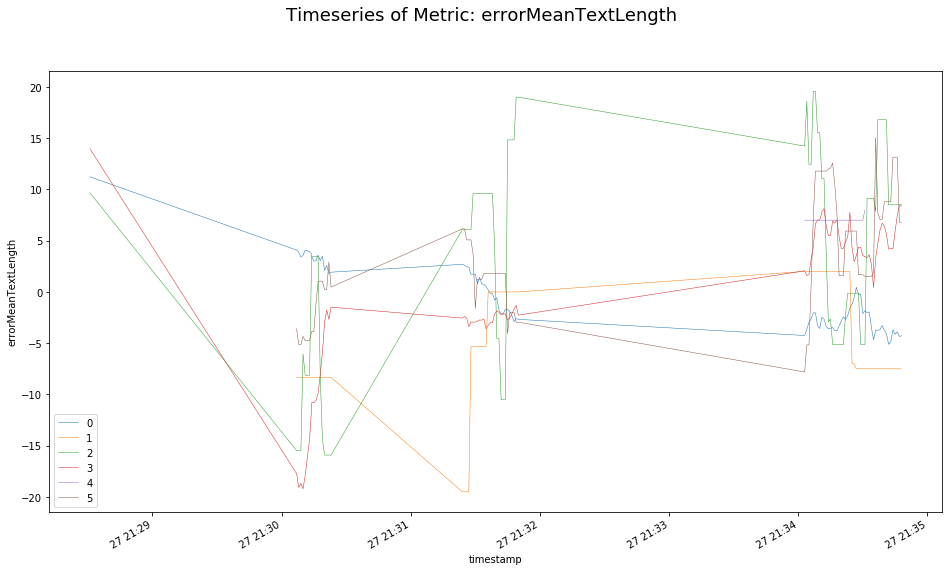

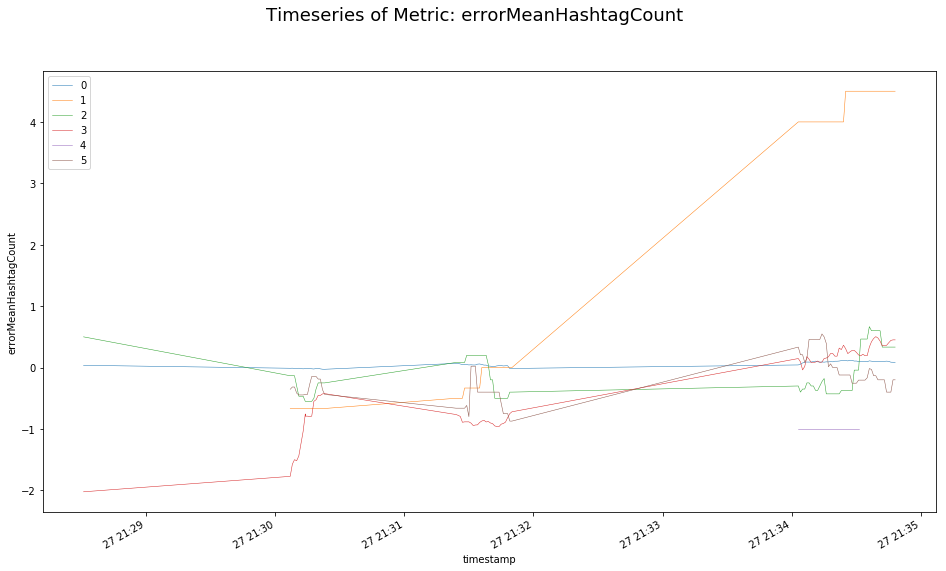

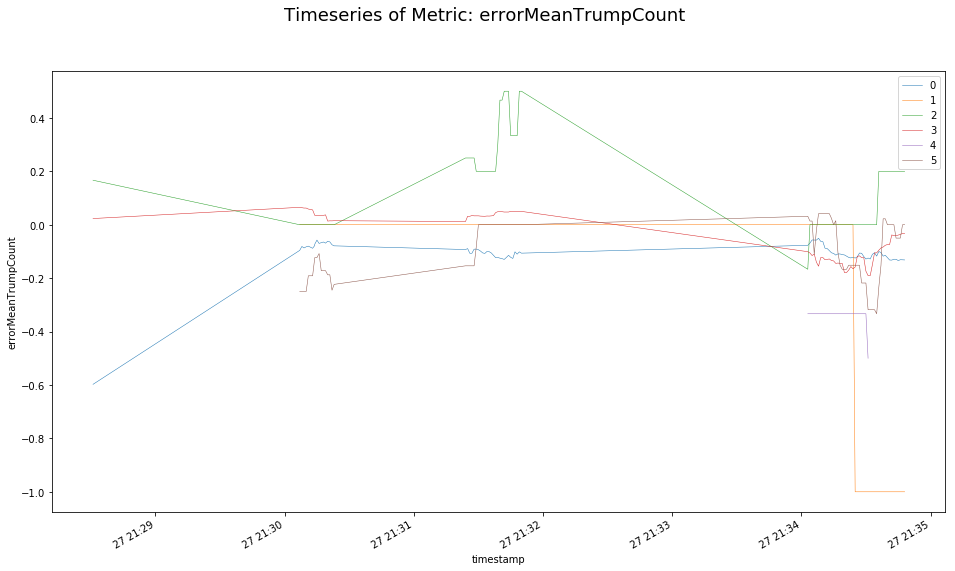

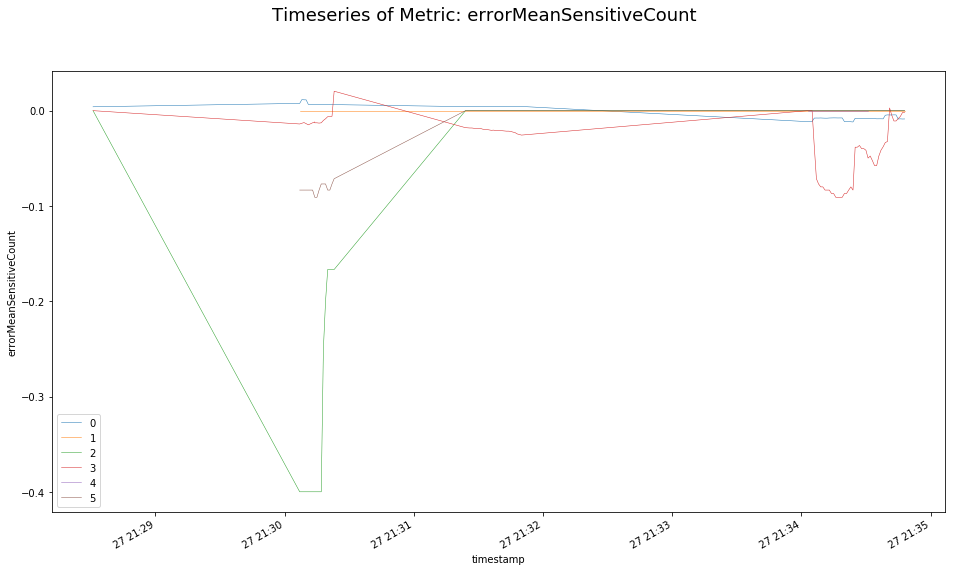

In [33]:
plotMetricTimeseries(evalTimeseriesList, 'errorCount')
plotMetricTimeseries(evalTimeseriesList, 'errorMeanTextLength')
plotMetricTimeseries(evalTimeseriesList, 'errorMeanHashtagCount')
plotMetricTimeseries(evalTimeseriesList, 'errorMeanTrumpCount')
plotMetricTimeseries(evalTimeseriesList, 'errorMeanSensitiveCount')

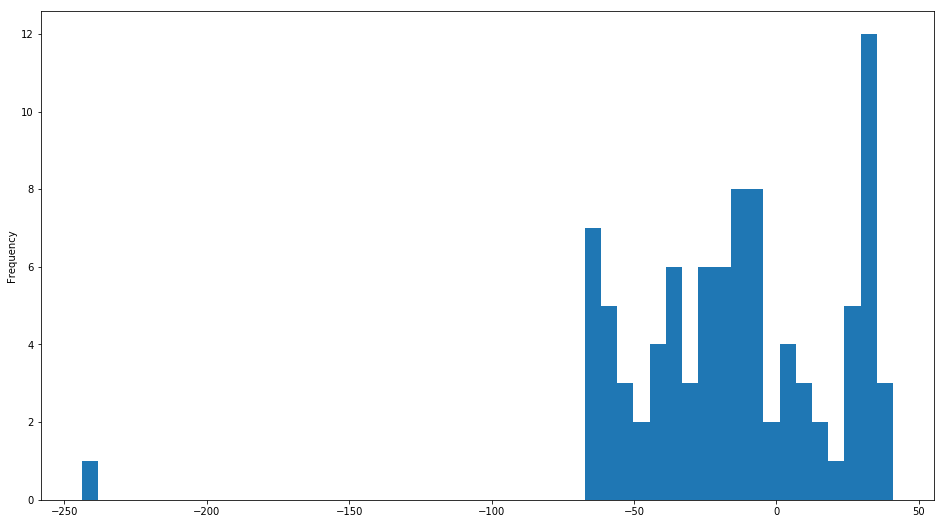

In [34]:
fig = plt.figure(figsize=(16,9))
evalTimeseriesList[0]['errorCount'].plot(kind='hist',bins=50)

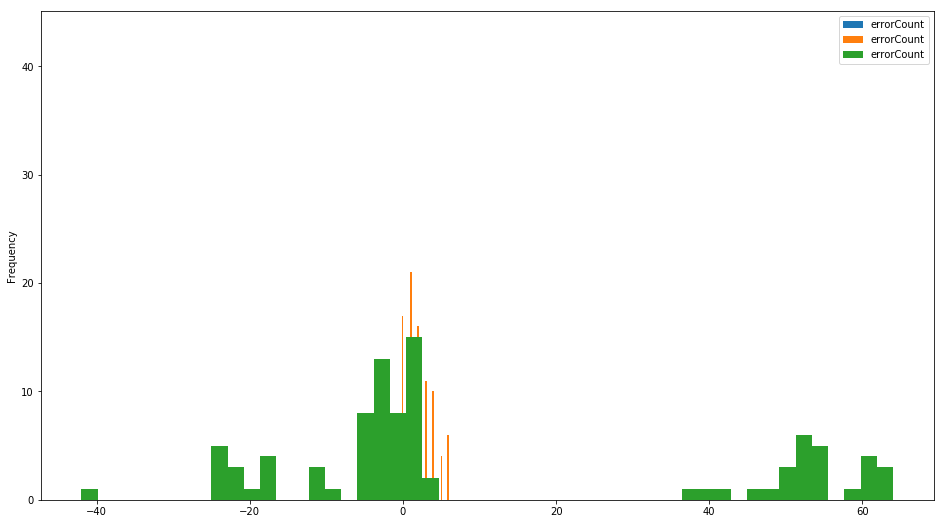

In [35]:
fig = plt.figure(figsize=(16,9))
evalTimeseriesList[1]['errorCount'].plot(kind='hist',bins=50)
evalTimeseriesList[2]['errorCount'].plot(kind='hist',bins=50)
evalTimeseriesList[3]['errorCount'].plot(kind='hist',bins=50)
plt.legend()